In [42]:
import math
import numpy as np
import csv
import matplotlib.pyplot as plt
import time

from scipy.io import loadmat

from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

mat = loadmat('q4_dataset.mat')

X = mat['inception_features']
images = mat['images']
y = mat['class_labels']

rng_state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(rng_state)
np.random.shuffle(y)

x_train_folds = []
y_train_folds = []
x_val_folds = []
y_val_folds = []
x_test_folds = []
y_test_folds = []

indices = [0, 250, 500, 750, 1000]

i = 0
average_acc_s =[]
for index in indices:
    X_train = []
    Y_train = []

    X_test = X[index:index + 250]
    Y_test = y[index:index + 250]

    X_val = X[(i + 1) % 5 * 250: (i + 1) % 5 * 250 + 250]
    Y_val = y[(i + 1) % 5 * 250: (i + 1) % 5 * 250 + 250]

    start = (i + 1) % 5 * 250 + 250
    
    for j in range(3):
        X_train_to_append = X[(start + j * 250) % 1250: (start + j * 250) % 1250 + 250]
        Y_train_to_append = y[(start + j * 250) % 1250: (start + j * 250) % 1250 + 250]

        X_train.append(X_train_to_append)
        Y_train.append(Y_train_to_append)
    
    x_train = np.array(X_train).reshape(750,2048)
    y_train = np.array(Y_train).reshape(750)
    x_test = np.array(X_test)
    y_test = np.array(Y_test)
    x_val = np.array(X_val)
    y_val = np.array(Y_val)
    
    x_train_folds.append(x_train)
    x_val_folds.append(x_val)
    
    y_train_folds.append(y_train)
    y_val_folds.append(y_val)
    
    x_test_folds.append(x_test)
    y_test_folds.append(y_test)
    
    
    i = i + 1
    
x_train_folds = np.array(x_train_folds)
y_train_folds = np.array(y_train_folds)
x_test_folds = np.array(x_test_folds)
y_test_folds = np.array(y_test_folds)
x_val_folds = np.array(x_val_folds)
y_val_folds = np.array(y_val_folds).reshape(5,250)

print(x_train_folds.shape)
print(x_val_folds.shape)
tempx = np.concatenate((x_train_folds,x_val_folds),axis = 1)
print(tempx.shape)
print(y_train_folds.shape)
print(y_val_folds.shape)
tempy = np.concatenate((y_train_folds,y_val_folds),axis = 1)
print(tempy.shape)

(5, 750, 2048)
(5, 250, 2048)
(5, 1000, 2048)
(5, 750)
(5, 250)
(5, 1000)


In [43]:
#Perform linear svm on folds
start = time.time()
C_values =[10**-6,10**-4,10**-2,1,10,10**10]
average_acc_s = []
for i in range(5):
    accs = []
    for c_i in range(len(C_values)):
        print(f'C: {C_values[c_i]}')
        model = OneVsRestClassifier(svm.LinearSVC(C=C_values[c_i]))
        model.fit(x_train_folds[i],y_train_folds[i])
        prediction = model.predict(x_val_folds[i])
        accuracy = accuracy_score(y_val_folds[i],prediction)
        accs.append(accuracy)
    print(np.array(accs))
    average_acc_s.append(np.array(accs))

average_acc_s = np.array(average_acc_s)
means = np.mean(average_acc_s, axis = 0)
index = np.where(means == np.amax(means))
C_found = C_values[index[0][0]]

# model = OneVsRestClassifier(svm.SVC(kernel='linear',C=C_found))
# prediction = model.predict(x_test)
for i in range(5):
    model = OneVsRestClassifier(svm.SVC(kernel='linear',C=C_found))
    model.fit(tempx[i],tempy[i])
    prediction = model.predict(x_test_folds[i])
    accuracy = accuracy_score(y_test_folds[i],prediction)
    print(f'Fold {i+1}s accuracy is:{accuracy}')
stop = time.time()    
print('Time elapsed in linear svm is ' + str(stop - start) )



C: 1e-06
C: 0.0001
C: 0.01
C: 1
C: 10
C: 10000000000
[0.62  0.732 0.7   0.696 0.696 0.696]
C: 1e-06
C: 0.0001
C: 0.01
C: 1
C: 10
C: 10000000000
[0.648 0.744 0.696 0.688 0.688 0.688]
C: 1e-06
C: 0.0001
C: 0.01
C: 1
C: 10
C: 10000000000
[0.604 0.792 0.768 0.76  0.76  0.76 ]
C: 1e-06
C: 0.0001
C: 0.01
C: 1
C: 10
C: 10000000000
[0.56  0.76  0.728 0.728 0.728 0.728]
C: 1e-06
C: 0.0001
C: 0.01
C: 1
C: 10
C: 10000000000
[0.656 0.78  0.748 0.744 0.744 0.744]
Fold 1s accuracy is:0.772
Fold 2s accuracy is:0.732
Fold 3s accuracy is:0.764
Fold 4s accuracy is:0.812
Fold 5s accuracy is:0.74
Time elapsed in linear svm is 59.62848520278931


In [44]:
C_found
x_val.shape

0.0001

In [55]:
C_values = [10**-6,10**-4,10**-2,1,10,10**10]
gamma_values = [2**-4,2**-2,1,2**2,2**10,'scale']
average_acc_s = []
start = time.time()
for i in range(5):
    print(str(i+1) + " fold iteration ")
    print( " ******************* ")
    for c_i in range(len(C_values)):
        print(f'C: {C_values[c_i]}')
        accs = []
        for g_i in range(len(gamma_values)):
            print(f'gamma: {gamma_values[g_i]}')
            model = OneVsRestClassifier(svm.SVC( kernel= 'rbf', C=C_values[c_i],gamma=gamma_values[g_i]))
            model.fit(x_train_folds[i],y_train_folds[i])
            prediction = model.predict(x_val_folds[i])
            accuracy = accuracy_score(y_val_folds[i],prediction)
            accs.append(accuracy)
        print("For C: " + str(C_values[c_i]) + " with different gamma values accs are")
        print(np.array(accs))
        average_acc_s.append(np.array(accs))

average_acc_s = np.array(average_acc_s)
    
    
    
stop = time.time()    
print('Time elapsed in linear svm is ' + str(stop - start) )

1 fold iteration 
 ******************* 
C: 1e-06
gamma: 0.0625
gamma: 0.25
gamma: 1
gamma: 4
gamma: 1024
gamma: scale
For C: 1e-06 with different gamma values accs are
[0.204 0.2   0.2   0.2   0.2   0.648]
C: 0.0001
gamma: 0.0625
gamma: 0.25
gamma: 1
gamma: 4
gamma: 1024
gamma: scale
For C: 0.0001 with different gamma values accs are
[0.204 0.2   0.2   0.2   0.2   0.648]
C: 0.01
gamma: 0.0625
gamma: 0.25
gamma: 1
gamma: 4
gamma: 1024
gamma: scale
For C: 0.01 with different gamma values accs are
[0.18 0.18 0.18 0.18 0.18 0.68]
C: 1
gamma: 0.0625
gamma: 0.25
gamma: 1
gamma: 4
gamma: 1024
gamma: scale
For C: 1 with different gamma values accs are
[0.18  0.18  0.18  0.18  0.18  0.728]
C: 10
gamma: 0.0625
gamma: 0.25
gamma: 1
gamma: 4
gamma: 1024
gamma: scale
For C: 10 with different gamma values accs are
[0.18  0.18  0.18  0.18  0.18  0.732]
C: 10000000000
gamma: 0.0625
gamma: 0.25
gamma: 1
gamma: 4
gamma: 1024
gamma: scale
For C: 10000000000 with different gamma values accs are
[0.18  0.1

In [77]:
for i in range(5):
    model = OneVsRestClassifier(svm.SVC(kernel='rbf',C=0.01,gamma = 'scale'))
    model.fit(tempx[i],tempy[i])
    prediction = model.predict(x_test_folds[i])
    accuracy = accuracy_score(y_test_folds[i],prediction)
    print(f'Fold {i+1}s accuracy is:{accuracy}')


Fold 1s accuracy is:0.72
Fold 2s accuracy is:0.704
Fold 3s accuracy is:0.712
Fold 4s accuracy is:0.728
Fold 5s accuracy is:0.692


C: 0.0001
[0.68, 0.656, 0.644, 0.692, 0.68]
C: 0.01
[0.72, 0.704, 0.712, 0.728, 0.692]
C: 1
[0.792, 0.744, 0.772, 0.824, 0.772]
C: 10
[0.788, 0.756, 0.784, 0.836, 0.78]
C: 10000000000
[0.784, 0.76, 0.784, 0.832, 0.78]


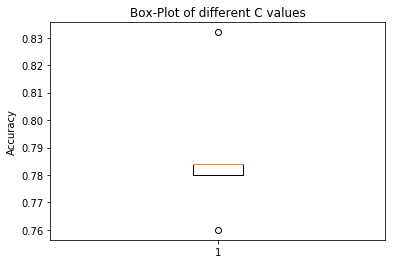

In [62]:
C_values = [10**-4,10**-2,1,10,10**10]

for c_i in range(len(C_values)):
    accs = []
    print(f'C: {C_values[c_i]}')
    for i in range(5):
        model = OneVsRestClassifier(svm.SVC(kernel='rbf',C=C_values[c_i],gamma = 'scale'))
        model.fit(tempx[i],tempy[i])
        prediction = model.predict(x_test_folds[i])
        accuracy = accuracy_score(y_test_folds[i],prediction)
        accs.append(accuracy)
    print(accs)

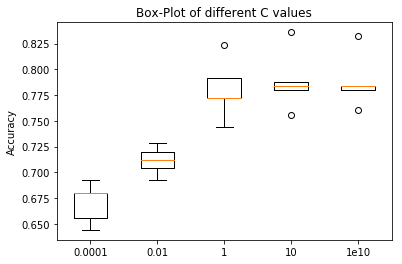

In [71]:
C_values = ['0.0001','0.01','1','10','1e10']
accs = [ [0.68, 0.656, 0.644, 0.692, 0.68],  [0.72, 0.704, 0.712, 0.728, 0.692], [0.792, 0.744, 0.772, 0.824, 0.772],[0.788, 0.756, 0.784, 0.836, 0.78],[0.784, 0.76, 0.784, 0.832, 0.78]  ]
fig = plt.figure() 
data = [accs[0],accs[1],accs[2],accs[3],accs[4]]
plt.boxplot(data) 
plt.title('Box-Plot of different C values')
plt.ylabel('Accuracy')
plt.xlabel('') 
plt.xticks([1, 2, 3, 4, 5], C_values)
plt.savefig('box_plot_c.png')
plt.show()

In [78]:
gamma_values = [2**-4,2**-2,1,2**2,2**10,'scale']
all_acc = []
for g_i in range(len(gamma_values)):
    accs = []
    print(f'g: {gamma_values[g_i]}')
    for i in range(5):
        model = OneVsRestClassifier(svm.SVC(kernel='rbf',C=0.01,gamma = gamma_values[g_i]))
        model.fit(tempx[i],tempy[i])
        prediction = model.predict(x_test_folds[i])
        accuracy = accuracy_score(y_test_folds[i],prediction)
        accs.append(accuracy)
    all_acc.append(accs)
    print(accs)

g: 0.0625
[0.164, 0.18, 0.172, 0.16, 0.188]
g: 0.25
[0.164, 0.18, 0.168, 0.16, 0.188]
g: 1
[0.164, 0.18, 0.168, 0.16, 0.188]
g: 4
[0.164, 0.18, 0.168, 0.16, 0.188]
g: 1024
[0.164, 0.18, 0.168, 0.16, 0.188]
g: scale
[0.72, 0.704, 0.712, 0.728, 0.692]


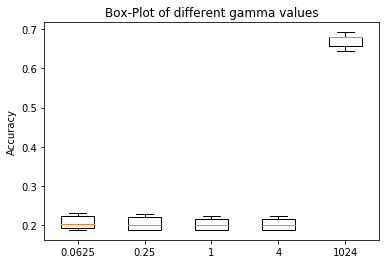

In [76]:
gamma_values = ['0.0625','0.25','1','4','1024','Scale']
accs = [ [0.188, 0.204, 0.224, 0.232, 0.192],  [0.188, 0.2, 0.22, 0.228, 0.188], [0.188, 0.2, 0.216, 0.224, 0.188],[0.188, 0.2, 0.216, 0.224, 0.188],[0.68, 0.656, 0.644, 0.692, 0.68]  ]
fig = plt.figure() 
data = [accs[0],accs[1],accs[2],accs[3],accs[4]]
plt.boxplot(data) 
plt.title('Box-Plot of different gamma values')
plt.ylabel('Accuracy')
plt.xlabel('') 
plt.xticks([1, 2, 3, 4, 5], gamma_values)
plt.savefig('box_plot_gamma.png')
plt.show()

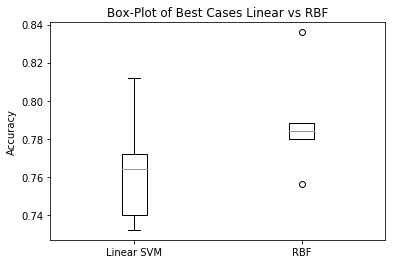

In [79]:
# For linear best case
# Fold 1s accuracy is:0.772
# Fold 2s accuracy is:0.732
# Fold 3s accuracy is:0.764
# Fold 4s accuracy is:0.812
# Fold 5s accuracy is:0.74

#For rbf best case
#[0.788, 0.756, 0.784, 0.836, 0.78]

fig = plt.figure()
rbf = [0.788, 0.756, 0.784, 0.836, 0.78]
linear = [0.772,0.732,0.764,0.812,0.74]
data = [linear,rbf]
plt.boxplot(data) 
plt.title('Box-Plot of Best Cases Linear vs RBF')
plt.ylabel('Accuracy')
plt.xlabel('') 
plt.xticks([1, 2], ['Linear SVM','RBF'])
plt.savefig('both_plot_box.png')
plt.show()